# Detecting oscillations & other temporal dynamics as null-hypothesis testing in spectral domain

Existing (and one might say, the dominant) view of neural oscillation is that it is the default: magnetic & electrical recordings from the scalp and cortex are always composed of oscillations at every frequency, even if they are not readily visible in the time series or power spectrum. One important consequence is that effects of oscillations are for the most part constrained to measurement of relative power differences, either between experimental conditions, or between "oscillations" of different frequencies (e.g., bandratios). Another important consequence, of course, is the idea that neural dynamics is always oscillatory, and their visibility in the power spectrum depends on the synchrony of many sub-oscillators.

Spectral parameterization (FOOOF) is the first step towards delineating between aperiodic and periodic components from the power spectral density (PSD). Here, we explore the concept that neural oscillations, and other meaningful events with temporal structure, are deviations from a baseline (or null hypothesis) composed purely of linear stochastic noise (i.e., colored noise).

In [1]:
%matplotlib inline
import numpy as np
from scipy import random, signal
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
from neurodsp import sim
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.spines.right']=False
plt.rcParams['image.cmap'] = 'inferno'

(0, 2)

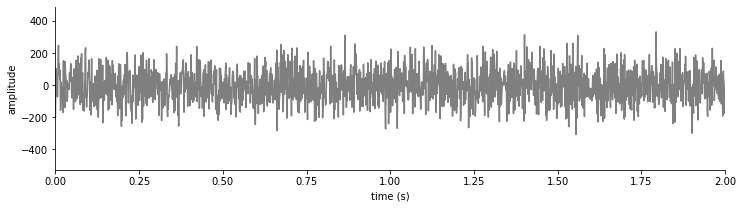

In [2]:
amp = 100
fs = 1000
T = 300
t = np.arange(0,T,1/fs)
sig = random.randn(fs*T)*amp

plt.figure(figsize=(12,3))
plt.plot(t, sig, 'k', alpha=0.5)
plt.xlabel('time (s)');plt.ylabel('amplitude')
plt.xlim([0,2])

In the cell above, we've generated white noise from a normal distribution, sampled at 1000Hz, and of a certain amplitude.

The main operation we'll be working with here is the conversion of the time series to a series of spectral estimates. We'll use short-time windowed Fourier Transform (STFT) here, but the ideas apply similarly to narrowband bandpass or wavelet transform and Hilbert Transformed data, with some caveats concerning filter bandwidth, etc.

STFT converts the time series into a collection of Fourier coefficients over time (`t_stft`), at frequencies (`f_stft`) determined by the STFT window length (`npserg`). Crucially, these coefficients are complex, from which the amplitude/power and phase are typically computed. But we can also visualize the coefficents as complex numbers in the 2D complex plane. 

Below, we compute the STFT, and plot a single time-slice of Fourier coefficients (at time 0, corresponding to the signal from t=0 to t=1), in the complex plane, as well as its power and phase spectra. This is not directly what we want to investigate, but builds towards the theoretical point.

In [3]:
nperseg=1000
f_stft, t_stft, stft = signal.stft(sig, fs, np.ones(nperseg), nperseg=nperseg, noverlap=0, boundary=None, return_onesided=False)

The STFT is performed above with some non-default parameter configurations, which are actually chosen to retrieve the unaltered per-window DFTs (otherwise, for example, applying a Hanning window alters some of the conserved quantities below).

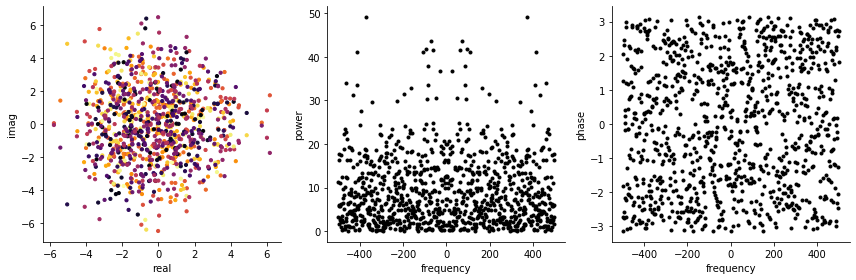

In [4]:
def plot_triplet(coefs, x_axis, x_label):
    plt.subplot(1,3,1)
    plt.scatter(coefs.real, coefs.imag, s=10, c=x_axis)
    plt.xlabel('real');plt.ylabel('imag');

    plt.subplot(1,3,2)
    plt.plot(x_axis, np.absolute(coefs)**2, '.k')
    plt.xlabel(x_label);plt.ylabel('power');

    plt.subplot(1,3,3)
    plt.plot(x_axis, np.angle(coefs), '.k')
    plt.xlabel(x_label);plt.ylabel('phase');
    plt.tight_layout()


# a single time-slice of STFT (one Fourier Transform)
plt.figure(figsize=(12,4))
plot_triplet(stft[:,0], f_stft, 'frequency')

In the above visualization of _single time-slice of the STFT_, we can observe some of the properties of the Fourier Transform. Namely, it is a linear projection of the time series onto the set of complex DFT bases. Because the signal we've generated is Gaussian and random, linear projection preserves this property, turning the 1D-Gaussian vector (time series) into a vector of 2D complex Gaussian distribution. Each dot in the plots above is the Fourier coefficient/power/phase at a _single frequency_, and the first subplot is colored by the frequency. You can see that it is a Gaussian blob and independent of frequency (color is not correlated to 2D position). Similarly, power and phase are randomly distributed over frequencies (we'll get to the specifics later). 

Side note: because we've included the negative frequencies in the STFT computation above (`return_onesided=False`), the coefficients are symmetric about the real axis, i.e., power is symmetric around 0Hz, and phase is anti-symmetric.

---

More formally stated, the Fourier coefficients at any given frequency (f) is a complex random variable (RV) that follows a particular distribution. The plots above look at the coefficients of all frequencies at a single time-slice. We can also look at the coefficients of a single frequency, over all time slices.

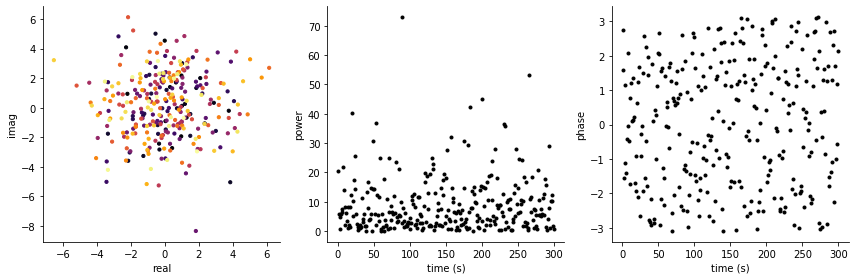

In [5]:
i_freq = 10
plt.figure(figsize=(12,4))
plot_triplet(stft[i_freq,:], t_stft, 'time (s)')

This plot looks similarly disordered as the one above, but is different in that it is aggregated across _time_, not _frequencies_ (hence losing the symmetry). However, the similarities reveal the key point: under the null hypothesis that the signal is linear stochastic noise, the coefficients at a single frequency across time is a R.V. that also follows the (complex) 2D Gaussian distribution. One can derive the appropriate distribution of power and phases accordingly. 


# Criterion 1: univariate distributions

For any given frequency, if $X(t)$ is the R.V. of complex coefficients, $P(t)$ the R.V. of power, and $\phi(t)$ the R.V. of phase:

Null hypothesis 1: $X \sim norm(\begin{bmatrix}0 \\0 \end{bmatrix}, \begin{bmatrix}s^2 & 0\\0 & s^2\end{bmatrix})$

NH 2: $P \sim \chi^2(2) = exp(<P>)$

NH 3: $\phi \sim uniform(-\pi, \pi)$

In words, $X$ follows a 2D isotropic Gaussian distribution (real and imag axes are independent, i.e., circular blob). 

$P$, the signal power or squared magnitude, is the sum of squares of 2 independent Gaussian R.V., hence follows the scaled chi-square distribution with DOF k=2 (equivalent to the exponential distribution), and $<P>$ is the average signal power (which defines the power spectrum), where $<P> = 2s^2$

$\phi$ is the phase angle of the 2D Gaussian blob, and is therefore uniformly distributed from $[-\pi, \pi]$

Checkout the same exact concept, but [in a physical context](https://stats.stackexchange.com/questions/65640/how-to-calculate-2d-standard-deviation-with-0-mean-bounded-by-limits).

In [6]:
print('2s^2 = %.4f, <P> = %.4f'%(np.std(stft[i_freq].real)**2+np.std(stft[i_freq].imag)**2, (np.absolute(stft[i_freq])**2).mean()))
# a little off because we are computing s as the sample standard deviation and <P> the sample average

print('sum of empirical covariance matrix diagonals: %.4f'%np.diag(np.cov([stft[i_freq].real, stft[i_freq].imag])).sum())

2s^2 = 9.0023, <P> = 9.0220
sum of empirical covariance matrix diagonals: 9.0324


---
### A small detour on white noise
In general, and especially for neural signals, $<p>$ and $s$ vary as a function of frequency. For the particular example of white noise, however, we can actually compute what s (and \<P\>) should be based on the signal variance. First, per Parseval's Theorem, the sum of squares of the time series equals to that of the Fourier Transform. Note that by default, scipy.stft normalizes the FT by nperseg to return the spectral _density_, i.e., preserving signal variance, not _sum of squares_.

In [7]:
ss_ts = ((sig[:1000])**2).sum()
ss_ft = (abs(stft[:,0])**2).sum()
print('simulation signal variance: %.4f |variance from sum of squares: time series: %.4f, frequency spectrum: %.4f'%(amp**2, ss_ts/nperseg, ss_ft))

simulation signal variance: 10000.0000 |variance from sum of squares: time series: 9375.0861, frequency spectrum: 9375.0861


For Gaussian noise with standard deviation `amp`, the signal variance is simply $var = amp^2$, which is the sum of squares divided by signal length. This is the total signal variance, which is then divided equally (for white noise only) across all frequencies. Therefore, for a DFT/STFT with `nfft = nperseg = 1000` (chosen by default), average power at each frequency is: $<P> = \frac{amp^2}{nfft} = \frac{10000}{1000} = 10$. The power spectral density will be this number across all frequencies, with variation that decreases with increasing signal length. Then, $s = \sqrt{\frac{<P>}{2}}$

sqrt(<P>/2) = 2.1239, s (real) = 2.0494, s (imag) = 2.1914


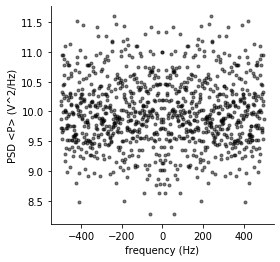

In [8]:
psd = (abs(stft)**2).mean(1)
plt.figure(figsize=(4,4))
plt.plot(f_stft, psd, 'k.', alpha=0.5)
plt.xlabel('frequency (Hz)');plt.ylabel('PSD <P> (V^2/Hz)');
print('sqrt(<P>/2) = %.4f, s (real) = %.4f, s (imag) = %.4f'%((psd[i_freq]/2)**.5, np.std(stft[i_freq].real), np.std(stft[i_freq].imag)))

These numbers are all a little off because they are finite sample-estimates.
### end of detour
___

# Criterion 2: dependence across frequencies

Since $X(t)$ at each frequency is random variable, in the case of uncorrelated noise, there should be no correlation between $X_{f1}(t)$ and $X_{f2}(t)$, for any two frequencies $f_1, f_2$. This is similarly true for $P(t)$. Thus, we can compute the pairwise correlation matrix for power, and average phase difference, between frequencies across time.

(__Note/to-do__: we can directly measure relationship between the 2D Gaussian RVs as well, but with a more complicated definition of covariance. In fact, operating directly on the complex numbers should detect amplitude-amplitude and phase-amplitude coupling "for free". In practice, we can implement complex covariance/correlation (which np.corrcoef automatically does), or coherence.)

In [9]:
def compute_coh(stft, mag_normed=True):
    """
    Compute the average vector difference between pairs of frequencies.
    The STFT is magnitude-normalized by default, such that the resulting output is a 
    square matrix of complex numbers representing the average difference vector between pair-wise frequencies. 
    The magnitude of the elements represents the degree of phase coherence, the phase represents the phase difference.
    
    When not normalized by magnitudes, the result is a magnitude-weighted coherence.
    
    Note that the resulting matrix is very similar to the complex covariance, except the cross terms are taken to be zero here.
    """
    n_freqs = stft.shape[0]
    # compute the complex conjugate product between every pair of frequency
    if mag_normed:
        # normalize by magnitude to get unit-lengthed vectors
        return np.array([(s*(stft/abs(stft)).conj()).mean(1) for s in (stft/abs(stft))])
    else:
        return np.array([(s*(stft).conj()).mean(1) for s in stft])

In [10]:
# just use the positive frequencies now that we've made the point about conservation of variance
stft_pos = stft[f_stft>=0]
f_stft_pos = f_stft[f_stft>=0]
stft_magnormed = stft_pos/abs(stft_pos)

# power correlation
ft_power = abs(stft_pos)**2 # otherwise known as spectrogram
corrmat_power = np.corrcoef(np.log10(ft_power)) # compute correlation matrix on log-power: more normally distributed

# phase coherence across frequencies
ft_coh = compute_coh(stft_pos)

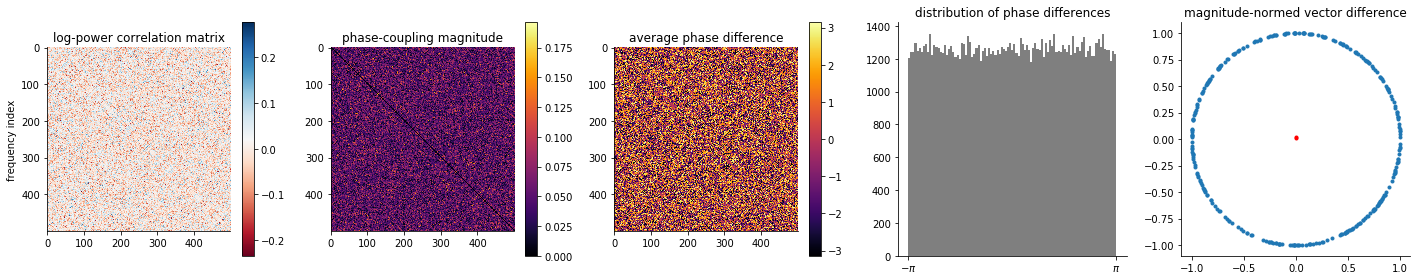

In [11]:
n_freqs = len(f_stft_pos)

plt.figure(figsize=(20,4))
plt.subplot(1,5,1)

# subtract out identity matrix so color is scaled better without diagonal 1s
plt.imshow(corrmat_power-np.eye(ft_power.shape[0]), cmap='RdBu')
plt.ylabel('frequency index')
plt.colorbar(); plt.title('log-power correlation matrix')

plt.subplot(1,5,2)
plt.imshow(abs(ft_coh)-np.eye(ft_power.shape[0]))
plt.colorbar(); plt.title('phase-coupling magnitude')

plt.subplot(1,5,3)
plt.imshow(np.angle(ft_coh))
plt.colorbar(); plt.title('average phase difference')

plt.subplot(1,5,4)
plt.hist(np.angle(ft_coh[np.triu_indices(n_freqs,1)]), np.linspace(-np.pi, np.pi, 100), color='k', alpha=0.5);
plt.title('distribution of phase differences')
plt.xticks([-np.pi, np.pi], [r'$-\pi$', r'$\pi$'])

plt.subplot(1,5,5)
# pick two frequencies to compute the complex conjugate product, and plot all as vectors
vecdiff_exmp = stft_magnormed[i_freq]*stft_magnormed[i_freq+10].conj()
plt.plot(vecdiff_exmp.real, vecdiff_exmp.imag, '.')
plt.plot([0,0],[vecdiff_exmp.mean().real, vecdiff_exmp.mean().imag], '.-r')
plt.title('magnitude-normed vector difference')

plt.tight_layout()

The above plots demonstrate the lack of discernable relationships across frequencies in both power and phase, as expected for the null hypothesis:
1. no correlation in power across frequencies
2. no phase coupling across frequencies (max is 1)
3. & 4. average phase difference between frequencies over time is also uniformly distributed, i.e., no phase delay preference.

In fact, we can once again set null hypotheses as parametric distributions that the above quantities should follow, in the case of stochastic noise. For example, Pearson correlation of two logged-exponential variables ($log_{10}P_{f}(t)$) has some null distribution one can derive (I don't know what it is off the top of my head). 

For magnitude-normalized phase-coupling magnitude and phase difference: the complex conjugate product of the Fourier coefficients of a pair of frequencies is uniformly distributed around the unit circle across time (last subplot). Each pixel in the second and third subplot is the magnitude and the phase of the average vector in the fifth plot (red).

### __How should the average magnitude and phase difference be distributed?__

---
# Criterion 3: structure over time

Lastly, because $X(t)$ at each frequency is a Gaussian R.V., there is no temporal autocorrelation at each frequency (this is only true if overlap between STFT windows is small, we used 0 above). As such, we can examine the power and phase autocorrelation/power spectrum, or the average phase advance (instantaneous frequency, e.g., see Fransen et al., 2015 NeuroImage), at each frequency. Similarly, we can look at the autocorrelation (lag-correlation) of the complex variables themselves, using the same definition of complex correlation. 

In general, though, since STFT is so sparsely sampled in time (every 0.5 or 1 second, whatever the step-size is), this will not find fast temporal structures when used with STFT-estimates, only long-term, potentially experimental trial-related temporal structures. Bandpass/wavelet-Hilbert spectral estimates will resolve finer-grain temporal autocorrelations.

Moreover, research looking at long-range temporal correlation (LRTC) of neural oscillations commonly employ nonlinear measures such as detrended fluctuation analysis, which similarly measures fluctuation at different timescales.

In [12]:
ft_acf = np.array([acf(np.log(p), nlags=20) for p in ft_power])
ft_phadv = (stft_magnormed[:,1:]*stft_magnormed[:,:-1].conj())

/Users/rdgao/opt/anaconda3/envs/voytek/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


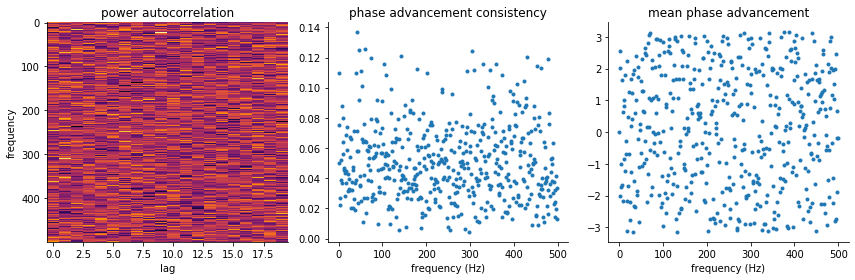

In [13]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(ft_acf[:,1:], aspect='auto')
plt.xlabel('lag'); plt.ylabel('frequency'); plt.title('power autocorrelation')

plt.subplot(1,3,2)
plt.plot(f_stft_pos, abs(ft_phadv.mean(1)), '.')
plt.xlabel('frequency (Hz)'); plt.title('phase advancement consistency');

plt.subplot(1,3,3)
plt.plot(f_stft_pos, np.angle(ft_phadv.mean(1)), '.')
plt.xlabel('frequency (Hz)'); plt.title('mean phase advancement');

plt.tight_layout()

As expected, there are no autocorrelation of spectral power at any frequency, and no consistent phase advancement at any frequency.

---

# Detecting oscillations
From this perspective, oscillations (or any other temporally structured events) can be defined as deviations from the above specified distributions under the null hypotheses, for the 3 criteria. We can set up a series of statistical tests to compare data against the hypothesized parametric null distributions, or even use simulated white (or colored) noise signals as a way to generate distributions (as we did above) for non-parametric tests.

### for single frequencies:
1. compute summary statistics - e.g., spectral power CV, skew.
2. fit parametric distributions and test against null hypotheses stated in Criterion 1. Failure indicates significant deviations from noise.
3. optimized fitting of parametric distributions to subset of the data to maximize data likelihood (or other metric, e.g., KS test), and detect out-of-distribution samples as events (outlier detection). Can then label each data point with a probabilistic oscillation score.
4. characterize temporal structure of spectral coefficients (e.g., power autocorrelation, phase advancement)

### across multiple frequencies:

5. detect correlation structure across frequencies (e.g., percentile spectrum, neighbor phase coupling, spectral PCA a la Kai Miller)
6. spectral power histograms
7. iteratively fit parametric distributions at each frequency and the power spectrum via FOOOF (Bayesian FOOOF) to separate aperiodic (and specifically, stochastic) background from structured events
